<a href="https://colab.research.google.com/github/HasithaGallella/EN3160-Image-Processing-and-Machine-Vision/blob/main/Assignments/EN3160_210174X_A03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**EN3160 Assignment 03:** Neural Networks

- Name: M.M.H.H.B Gallella
- Index No.: 210174X
- Submission Date: 14th November 2024
- GitHub: [https://github.com/HasithaGallella](https://github.com/HasithaGallella)
- Assignment Codes on: [Google Colab](https://colab.research.google.com/drive/1ZJZJ3tKyZb-z723Q6nkNKsan-WjYtS1B?usp=sharing)

# Check CUDA setup

In [ ]:
import torch
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 2060


In [ ]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# 1] Dense layer network with manually computed forward path and backpropagations for CIFAR10 dataset

In [ ]:
import torch
import torch.nn as nn  # Import neural network module
import torch.optim as optim  # Import optimization algorithms
import torchvision  # Import torchvision for datasets and image manipulation
import torchvision.transforms as transforms  # Import image transformation utilities
import matplotlib.pyplot as plt  # Import for plotting graphs

In [ ]:
# 1. Dataloading
transform = transforms.Compose([  # Define a sequence of image transformations
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images with mean and standard deviation
])

batch_size = 50  # Define batch size for loading data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,  # Load CIFAR-10 training dataset
                                         download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,  # Create DataLoader for training set
                                          shuffle=True, num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,  # Load CIFAR-10 test dataset
                                        download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,  # Create DataLoader for test set
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',  # List of CIFAR-10 class names
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


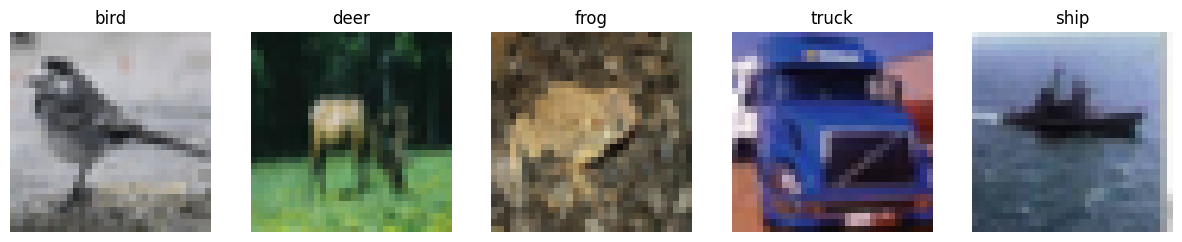

In [ ]:
# Get a batch of training data
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Plot the first 5 images, one from each class
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
found_classes = set()
count = 0

for i in range(len(labels)):
    if labels[i].item() not in found_classes:
        # Since images are normalized, unnormalize them for visualization
        img = images[i] / 2 + 0.5  # Unnormalize the image
        img = img.numpy()
        axes[count].imshow(np.transpose(img, (1, 2, 0)))
        axes[count].set_title(f'{classes[labels[i]]}')
        axes[count].axis('off')
        found_classes.add(labels[i].item())
        count += 1
    if count == 5:
        break

plt.show()

In [ ]:
# 2. Define Network Parameters
Din = 3 * 32 * 32  # Input size (flattened CIFAR10 image size)
H = 100  # Number of nodes in the hidden layer
K = 10  # Output size (number of classes in CIFAR10)
std = 1e-5  # Standard deviation for weight initialization

# Initialize weights and biases
w1 = torch.randn(Din, H) * std  # Weights for input to hidden layer, initialized randomly
b1 = torch.zeros(H)  # Bias for hidden layer, initialized to zero
w2 = torch.randn(H, K) * std  # Weights for hidden to output layer, initialized randomly
b2 = torch.zeros(K)  # Bias for output layer, initialized to zero

# Hyperparameters
iterations = 10  # Number of training iterations
lr = 1e-3  # Learning rate
lr_decay = 0.9  # Learning rate decay factor
reg = 0  # Regularization strength
loss_history = []  # List to store loss values for plotting

# Cross-Entropy Loss Function
def cross_entropy_loss(y_pred, y_true):  # Custom cross-entropy loss function
    return -torch.sum(y_true * torch.log(y_pred + 1e-9)) / y_true.shape[0]  # Calculate loss

# Sigmoid Activation Function
def sigmoid(x):  # Define sigmoid activation function
    return 1 / (1 + torch.exp(-x))  # Apply sigmoid to input

# 3. Training Loop
for t in range(iterations):  # Iterate through epochs
    running_loss = 0.0  # Initialize running loss for each epoch
    correct = 0  # Initialize correct predictions count
    total = 0  # Initialize total sample count

    for i, data in enumerate(trainloader, 0):  # Loop through training batches
        # Get inputs and labels
        inputs, labels = data  # Unpack data (inputs and labels)
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input to (Ntr, Din)
        y_train_onehot = nn.functional.one_hot(labels, K).float()  # Convert labels to one-hot encoding

        # Forward pass - Hidden Layer
        hidden_output = sigmoid(x_train.mm(w1) + b1)  # Calculate hidden layer output
        # Forward pass - Output Layer
        y_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)  # Calculate output layer predictions

        # Loss calculation (Cross-Entropy Loss with regularization)
        loss = cross_entropy_loss(y_pred, y_train_onehot) + reg * (torch.sum(w1 ** 2) + torch.sum(w2 ** 2))  # Compute loss
        loss_history.append(loss.item())  # Store loss value
        running_loss += loss.item()  # Accumulate running loss

        # Backpropagation
        dy_pred = y_pred - y_train_onehot  # Derivative of loss w.r.t output
        dw2 = hidden_output.t().mm(dy_pred) + reg * w2  # Gradient for w2
        db2 = dy_pred.sum(dim=0)  # Gradient for b2
        dhidden = dy_pred.mm(w2.t()) * hidden_output * (1 - hidden_output)  # Derivative for hidden layer
        dw1 = x_train.t().mm(dhidden) + reg * w1  # Gradient for w1
        db1 = dhidden.sum(dim=0)  # Gradient for b1

        # Parameter update
        w1 -= lr * dw1  # Update weights for input to hidden layer
        b1 -= lr * db1  # Update bias for hidden layer
        w2 -= lr * dw2  # Update weights for hidden to output layer
        b2 -= lr * db2  # Update bias for output layer

        # Calculate accuracy
        _, predicted = torch.max(y_pred, 1)  # Get predicted class index
        total += labels.size(0)  # Update total samples
        correct += (predicted == labels).sum().item()  # Update correct predictions count

    train_accuracy = 100 * correct / total  # Calculate training accuracy
    print(f'Epoch [{t + 1}/{iterations}], Loss: {running_loss / len(trainloader):.4f}, Training Accuracy: {train_accuracy:.2f}%')  # Print epoch stats

    # Learning rate decay
    lr *= lr_decay  # Apply learning rate decay

Epoch [1/10], Loss: 2.1591, Training Accuracy: 16.74%
Epoch [2/10], Loss: 1.9055, Training Accuracy: 30.71%
Epoch [3/10], Loss: 1.8063, Training Accuracy: 35.76%
Epoch [4/10], Loss: 1.7478, Training Accuracy: 38.15%
Epoch [5/10], Loss: 1.7082, Training Accuracy: 39.92%
Epoch [6/10], Loss: 1.6797, Training Accuracy: 41.34%
Epoch [7/10], Loss: 1.6568, Training Accuracy: 42.10%
Epoch [8/10], Loss: 1.6378, Training Accuracy: 42.92%
Epoch [9/10], Loss: 1.6215, Training Accuracy: 43.80%
Epoch [10/10], Loss: 1.6069, Training Accuracy: 44.23%


This is a simple neural network with one hidden layer, applied to the CIFAR-10 dataset. The architecture and training use the cross-entropy loss function and stochastic gradient descent (SGD) for parameter updates.

#### 1. Network Parameters
- **Input Size (`Din`)**: The input size is $3 \times 32 \times 32 = 3072$, which corresponds to the flattened image from CIFAR-10 (32x32 with 3 color channels).
- **Hidden Layer Size (`H`)**: The number of hidden units is 100.
- **Output Size (`K`)**: The output size is 10, which corresponds to the 10 classes in CIFAR-10.

The weights and biases are initialized as follows:
- $W_1 \in \mathbb{R}^{3072 \times 100}$, $b_1 \in \mathbb{R}^{100}$ are weights and biases for the input to hidden layer.
- $W_2 \in \mathbb{R}^{100 \times 10}$, $b_2 \in \mathbb{R}^{10}$ are weights and biases for the hidden to output layer.

#### 2. Forward Propagation Equations
- **Hidden Layer Computation**:
  $$
  h = \sigma(XW_1 + b_1)
  $$
  Where:
  - $X \in \mathbb{R}^{N \times 3072}$ is the batch of input data, where $N$ is the batch size.
  - $W_1 \in \mathbb{R}^{3072 \times 100}$ are the weights from input to hidden layer.
  - $b_1 \in \mathbb{R}^{100}$ is the bias for the hidden layer.
  - $\sigma$ is the sigmoid activation function defined as:
    $$
    \sigma(x) = \frac{1}{1 + e^{-x}}
    $$

- **Output Layer Computation**:
  $$
  y_{\text{pred}} = \text{softmax}(h W_2 + b_2)
  $$
  Where:
  - $h \in \mathbb{R}^{N \times 100}$ is the output from the hidden layer.
  - $W_2 \in \mathbb{R}^{100 \times 10}$ are the weights from hidden to output layer.
  - $b_2 \in \mathbb{R}^{10}$ is the bias for the output layer.
  - **Softmax function** is used to produce a probability distribution over the output classes:
    $$
    \text{softmax}(z_j) = \frac{e^{z_j}}{\sum_{k=1}^{K} e^{z_k}}
    $$
    Where $z_j$ is the $j$-th element of the input to softmax, representing the score for class $j$.

#### 3. Cross-Entropy Loss
The **cross-entropy loss** is used to measure the difference between the predicted output and the true labels:
$$
\mathcal{L} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{K} y_{ij} \log(y_{\text{pred}, ij})
$$
Where:
- $y_{ij}$ is the true label (one-hot encoded) for the $i$-th sample and class $j$.
- $y_{\text{pred}, ij}$ is the predicted probability for the $i$-th sample and class $j$.

#### 4. Backpropagation and Gradients
The gradients for backpropagation are calculated as follows:

- **Gradient w.r.t. Output Weights $W_2$**:
  $$
  \frac{\partial \mathcal{L}}{\partial W_2} = h^T (y_{\text{pred}} - y)
  $$
  Where:
  - $y_{\text{pred}} - y$ is the difference between the predicted and true labels.

- **Gradient w.r.t. Output Bias $b_2$**:
  $$
  \frac{\partial \mathcal{L}}{\partial b_2} = \sum_{i=1}^{N} (y_{\text{pred},i} - y_i)
  $$

- **Gradient w.r.t. Hidden Layer Output**:
  $$
  \delta_h = (y_{\text{pred}} - y) W_2^T \cdot h \cdot (1 - h)
  $$
  Where $\delta_h$ represents the gradient flowing back to the hidden layer. The term $h \cdot (1 - h)$ is the derivative of the sigmoid function.

- **Gradient w.r.t. Hidden Weights $W_1$**:
  $$
  \frac{\partial \mathcal{L}}{\partial W_1} = X^T \delta_h
  $$

- **Gradient w.r.t. Hidden Bias $b_1$**:
  $$
  \frac{\partial \mathcal{L}}{\partial b_1} = \sum_{i=1}^{N} \delta_{h_i}
  $$

#### 5. Parameter Updates Using Gradient Descent
Using **Stochastic Gradient Descent (SGD)**, the weights are updated as follows:

- **Update Rule for Weights**:
  $$
  W_1 = W_1 - \eta \frac{\partial \mathcal{L}}{\partial W_1}
  $$
  $$
  W_2 = W_2 - \eta \frac{\partial \mathcal{L}}{\partial W_2}
  $$
  Where $\eta$ is the learning rate.

- **Update Rule for Biases**:
  $$
  b_1 = b_1 - \eta \frac{\partial \mathcal{L}}{\partial b_1}
  $$
  $$
  b_2 = b_2 - \eta \frac{\partial \mathcal{L}}{\partial b_2}
  $$

These equations reflect the application of backpropagation and gradient descent to update the weights and biases in the network based on the cross-entropy loss function.

### Main code blocks;
- **Forward Pass**: Computes the output of the network using sigmoid activation in the hidden layer and softmax in the output layer.
- **Loss Calculation**: Uses cross-entropy loss to measure the error between predictions and true labels.
- **Backpropagation**: Computes the gradients for each weight and bias.
- **Parameter Update**: Applies SGD to update weights and biases based on computed gradients, following the equations shown in the image.


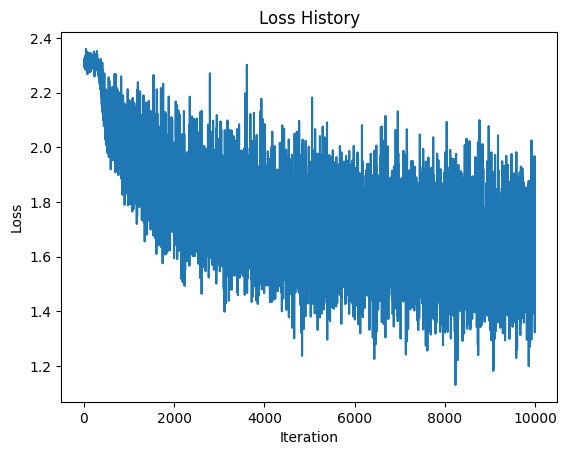

In [ ]:
# 4. Plotting the Loss History
plt.plot(loss_history)  # Plot loss over iterations
plt.title("Loss History")  # Plot title
plt.xlabel("Iteration")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.show()  # Display plot

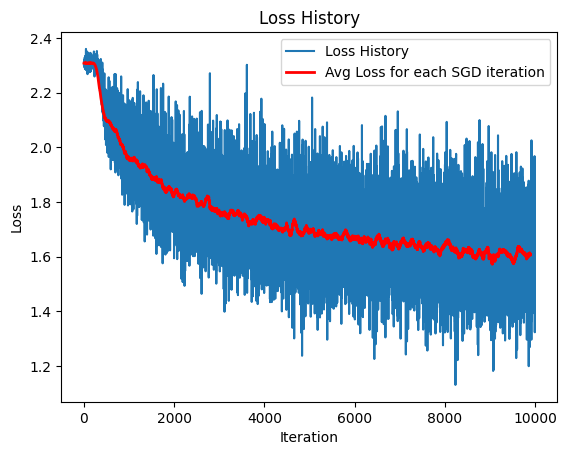

In [ ]:
# 4. Plotting the Loss History
plt.plot(loss_history, label='Loss History')  # Plot loss over iterations
smoothed_loss = np.convolve(loss_history, np.ones(100)/100, mode='valid')  # Calculate smoothed loss using moving average
plt.plot(smoothed_loss, color='r', linewidth=2, label='Avg Loss for each SGD iteration')  # Plot the smoothed loss as a red line
plt.title("Loss History")  # Plot title
plt.xlabel("Iteration")  # X-axis label
plt.ylabel("Loss")  # Y-axis label
plt.legend()  # Display legend
plt.show()  # Display plot

In [ ]:
# 5. Calculate Accuracy on Training Set
correct_train = 0  # Initialize correct count for training set
total_train = 0  # Initialize total sample count for training set
with torch.no_grad():  # Disable gradient computation
    for data in trainloader:  # Loop through training data
        inputs, labels = data  # Unpack data
        Ntr = inputs.shape[0]  # Batch size
        x_train = inputs.view(Ntr, -1)  # Flatten input

        # Forward pass
        hidden_output = sigmoid(x_train.mm(w1) + b1)  # Calculate hidden layer output
        y_train_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)  # Calculate output layer predictions
        predicted_train = torch.argmax(y_train_pred, dim=1)  # Get predicted class
        total_train += labels.size(0)  # Update total count
        correct_train += (predicted_train == labels).sum().item()  # Update correct count

train_acc = 100 * correct_train / total_train  # Calculate training accuracy
print(f"Training accuracy: {train_acc:.2f}%")  # Print training accuracy

Training accuracy: 44.72%


In [ ]:
# 6. Calculate Accuracy on Test Set
correct_test = 0  # Initialize correct count for test set
total_test = 0  # Initialize total sample count for test set
with torch.no_grad():  # Disable gradient computation
    for data in testloader:  # Loop through test data
        inputs, labels = data  # Unpack data
        Nte = inputs.shape[0]  # Batch size
        x_test = inputs.view(Nte, -1)  # Flatten input

        # Forward pass
        hidden_output = sigmoid(x_test.mm(w1) + b1)  # Calculate hidden layer output
        y_test_pred = torch.softmax(hidden_output.mm(w2) + b2, dim=1)  # Calculate output layer predictions
        predicted_test = torch.argmax(y_test_pred, dim=1)  # Get predicted class
        total_test += labels.size(0)  # Update total count
        correct_test += (predicted_test == labels).sum().item()  # Update correct count

test_acc = 100 * correct_test / total_test  # Calculate test accuracy
print(f"Test accuracy: {test_acc:.2f}%")  # Print test accuracy

Test accuracy: 43.37%


# 2] Create a LeNet-5 network for MNIST Dataset using Pytorch

In [ ]:
import torch
import torch.nn as nn  # Import the neural network module
import torch.optim as optim  # Import optimization algorithms
import torchvision  # Import torchvision for datasets and image manipulation
import torchvision.transforms as transforms  # Import transforms for data preprocessing
from torch.utils.data import DataLoader  # Import DataLoader for batching data

### Check if GPU is available, otherwise use CPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## LeNet-5 Model Definition

1. First Convolutional Layer (Conv2D):
    - Input: 1 channel, Output: 6 channels, Kernel size: 5x5
    - Activation: ReLU
    - Max Pooling with kernel size 2x2, stride 2

2. Second Convolutional Layer (Conv2D):
    - Input: 6 channels, Output: 16 channels, Kernel size: 5x5
    - Activation: ReLU
    - Max Pooling with kernel size 2x2, stride 2

3. Flatten the Convolutional Output

4. First Fully Connected Layer (Dense Layer):
    - Input Size: 16 * 5 * 5, Output Size: 120
    - Activation: ReLU

5. Second Fully Connected Layer (Dense Layer):
    - Input Size: 120, Output Size: 84
    - Activation: ReLU

6. Output Layer (Dense Layer):
    - Input Size: 84, Output Size: 10 (Number of classes)


### PyTorch Method 1: Standard Layer-by-Layer Definition

In [ ]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):  # Define LeNet-5 model as a subclass of nn.Module
    def __init__(self):  # Constructor method to initialize the model layers
        super(LeNet5, self).__init__()  # Call the parent class constructor
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)  # First convolutional layer (input channels: 1, output channels: 6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)  # Second convolutional layer (input channels: 6, output channels: 16)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # First fully connected layer (input size: 16 * 5 * 5, output size: 120)
        self.fc2 = nn.Linear(120, 84)  # Second fully connected layer (input size: 120, output size: 84)
        self.fc3 = nn.Linear(84, 10)  # Third fully connected layer (input size: 84, output size: 10)

    def forward(self, x):  # Define the forward pass
        x = torch.relu(self.conv1(x))  # Apply ReLU activation to the output of the first convolutional layer
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling with kernel size 2 and stride 2
        x = torch.relu(self.conv2(x))  # Apply ReLU activation to the output of the second convolutional layer
        x = torch.max_pool2d(x, kernel_size=2, stride=2)  # Apply max pooling with kernel size 2 and stride 2
        x = x.view(-1, 16 * 5 * 5)  # Flatten the tensor to prepare for fully connected layers
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to the first fully connected layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to the second fully connected layer
        x = self.fc3(x)  # Output layer (no activation, logits for classification)
        return x  # Return the final output

### PyTorch Method 2: Using nn.Sequential for Convolution Layers

In [ ]:
import torch
import torch.nn as nn

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(6, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### TensorFlow Method 3: Functional

In [ ]:
import tensorflow as tf

def LeNet5(inputs):
    x = tf.keras.layers.Conv2D(6, kernel_size=5, strides=1, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = tf.keras.layers.Conv2D(16, kernel_size=5, strides=1, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(120, activation='relu')(x)
    x = tf.keras.layers.Dense(84, activation='relu')(x)
    x = tf.keras.layers.Dense(10, activation='softmax', name="classification")(x)
    return x

inputs = tf.keras.Input(shape=(32, 32, 1))
outputs = LeNet5(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

### TensorFlow Method 4: Sequential

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential()
model.add(Conv2D(6, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(32, 32, 1)))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(16, kernel_size=5, strides=1, activation='relu'))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

### Summary of the Four Approaches:

1. **PyTorch Method 1 (Standard Layer-by-Layer Definition)**:
   - PyTorch model layers are defined individually in the constructor.
   - This allows you to maintain flexibility, as each layer is instantiated separately.
   - Pros: Good for learning and understanding each layer individually. Fine control over the architecture.
   - Cons: Slightly verbose and harder to maintain as models grow more complex.

2. **PyTorch Method 2 (Using `nn.Sequential`)**:
   - Uses `nn.Sequential` to create a block of layers that are automatically stacked.
   - Simplifies the model definition by removing the need to write individual forward propagation.
   - Pros: Easier to write and maintain for simpler models. Reduces verbosity in the forward function.
   - Cons: Not as flexible if the model needs custom branching or multiple input/output.

3. **TensorFlow Method 3 (Functional API)**:
   - The Functional API provides explicit connectivity between each layer.
   - Useful for more advanced models that might need multiple inputs/outputs or branching.
   - Pros: Highly flexible, and good for any complex architecture. More explicit.
   - Cons: Verbose for simple models. More effort is needed to connect layers manually.

4. **TensorFlow Method 4 (Sequential API)**:
   - Defines the model as a linear stack of layers using `Sequential`.
   - Ideal for simple models without any need for branching.
   - Pros: Very easy to implement for straightforward models. Concise and readable.
   - Cons: Not suitable for complex architectures, such as those with shared layers or multiple paths.


### When to Use Each Approach:

- **PyTorch Layer-by-Layer & TensorFlow Functional API ()**:
  - Useful when you need the flexibility to define complex models, including shared weights, multiple inputs/outputs, and non-linear data flows.
  - Ideal for research and advanced model development where custom operations are required.

- ** PyTorch `nn.Sequential` & TensorFlow Sequential API**:
  - Ideal for simple feed-forward models or when developing models rapidly without needing branching structures.
  - Great for beginners or simple prototyping where the architecture is straightforward.

  

### Pros and Cons of Each Method:

| Method                          | Pros                                                      | Cons                                                        |
|---------------------------------|-----------------------------------------------------------|-------------------------------------------------------------|
| **PyTorch Layer-by-Layer**      | Fine control over individual layers and flexibility.      | More verbose, harder to maintain as models get complex.     |
| **PyTorch `nn.Sequential`**     | Concise and good for stacking layers directly.            | Less flexibility if you need to add different paths or custom operations. |
| **TensorFlow Functional API**   | Very flexible for complex architectures (e.g., multiple inputs/outputs). | Verbose for simple models, requires explicit layer connections. |
| **TensorFlow Sequential API**   | Very readable and easy for straightforward architectures. | Limited flexibility for complex model designs.              |



## Model, Loss, and Optimizer

In [ ]:
model = LeNet5().to(device)  # Instantiate the LeNet-5 model and move it to the appropriate device
criterion = nn.CrossEntropyLoss()  # Define the loss function (cross-entropy loss for classification)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # Define the optimizer (stochastic gradient descent with momentum)

## Data Preparation

In [ ]:
transform = transforms.Compose([  # Define a sequence of transformations for data preprocessing
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image with mean 0.5 and standard deviation 0.5
])

# Load MNIST dataset for training and testing
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Load training set
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)  # Load test set

# Create data loaders for batching training and test datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)  # DataLoader for training set (batch size: 64)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)  # DataLoader for test set (batch size: 1000)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 34.3MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.35MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.12MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### First few images from the batch

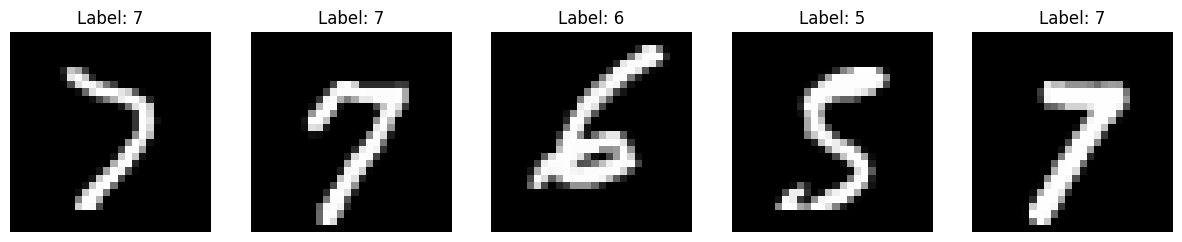

In [ ]:
# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Plot the first few images from the batch
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    # Since images are normalized, unnormalize them for visualization
    img = images[i] / 2 + 0.5  # Unnormalize the image
    img = img.numpy()
    axes[i].imshow(img[0], cmap='gray')
    axes[i].set_title(f'Label: {labels[i]}')
    axes[i].axis('off')

plt.show()

## Training Loop

In [ ]:
num_epochs = 10  # Number of epochs to train the model
for epoch in range(num_epochs):  # Loop over epochs
    model.train()  # Set the model to training mode
    running_loss = 0.0  # Initialize running loss
    correct = 0  # Initialize count of correct predictions
    total = 0  # Initialize total number of samples

    for images, labels in train_loader:  # Loop over training data in batches
        images, labels = images.to(device), labels.to(device)  # Move images and labels to the device

        # Forward pass
        outputs = model(images)  # Get model predictions
        loss = criterion(outputs, labels)  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
        total += labels.size(0)  # Update the total count of samples
        correct += (predicted == labels).sum().item()  # Update the count of correct predictions

    train_accuracy = 100 * correct / total  # Calculate training accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')  # Print epoch summary


Epoch [1/10], Loss: 0.4019, Training Accuracy: 86.69%
Epoch [2/10], Loss: 0.0632, Training Accuracy: 98.05%
Epoch [3/10], Loss: 0.0445, Training Accuracy: 98.61%
Epoch [4/10], Loss: 0.0363, Training Accuracy: 98.89%
Epoch [5/10], Loss: 0.0276, Training Accuracy: 99.14%
Epoch [6/10], Loss: 0.0238, Training Accuracy: 99.22%
Epoch [7/10], Loss: 0.0194, Training Accuracy: 99.39%
Epoch [8/10], Loss: 0.0169, Training Accuracy: 99.45%
Epoch [9/10], Loss: 0.0146, Training Accuracy: 99.54%
Epoch [10/10], Loss: 0.0121, Training Accuracy: 99.60%


In [ ]:
# Test the Model
def test():  # Define the function to test the model
    model.eval()  # Set the model to evaluation mode
    correct = 0  # Initialize count of correct predictions
    total = 0  # Initialize total number of samples
    with torch.no_grad():  # Disable gradient computation
        for images, labels in test_loader:  # Loop over test data in batches
            images, labels = images.to(device), labels.to(device)  # Move images and labels to the device
            outputs = model(images)  # Get model predictions
            _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
            total += labels.size(0)  # Update the total count of samples
            correct += (predicted == labels).sum().item()  # Update the count of correct predictions

    test_accuracy = 100 * correct / total  # Calculate test accuracy
    print(f'Test Accuracy: {test_accuracy:.2f}%')  # Print test accuracy

test()  # Call the test function to evaluate the model on the test set

Test Accuracy: 98.97%


# 3] Transfer learning a pre-trained ResNet18 network on ImageNet1K to classify Hymenoptera dataset.

In [ ]:
import torch
import torch.nn as nn  # Import neural network modules
import torch.optim as optim  # Import optimization algorithms
import torchvision  # Import torchvision for datasets and models
import torchvision.transforms as transforms  # Import transforms for image preprocessing
import torchvision.datasets as datasets  # Import datasets module for loading datasets
import torchvision.models as models  # Import models module for using pre-trained models
from torch.utils.data import DataLoader  # Import DataLoader for batching data
import matplotlib.pyplot as plt  # Import for plotting graphs
import os  # Import os for interacting with the operating system
import zipfile  # Import zipfile for extracting zip files
import urllib.request  # Import urllib to download files from the internet

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Set device to GPU if available, otherwise use CPU

## Data Preparation

In [ ]:
# Download and extract the dataset in Google Colab
url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"  # URL of the dataset
data_dir = "./hymenoptera_data"  # Directory to store the dataset

if not os.path.exists(data_dir):  # Check if the dataset directory exists
    urllib.request.urlretrieve(url, "hymenoptera_data.zip")  # Download the dataset zip file
    with zipfile.ZipFile("hymenoptera_data.zip", 'r') as zip_ref:  # Open the zip file
        zip_ref.extractall(".")  # Extract the contents of the zip file

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(256),  # Resize the image to 256 pixels on the shorter side
    transforms.CenterCrop(224),  # Crop the center of the image to 224x224 pixels
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize the image with mean and std values
])

# Load the training and test datasets
train_dataset = datasets.ImageFolder(root=f'{data_dir}/train', transform=transform)  # Load training dataset
test_dataset = datasets.ImageFolder(root=f'{data_dir}/val', transform=transform)  # Load validation dataset

# Create data loaders for batching the data
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)  # DataLoader for training set
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)  # DataLoader for test set

##  Load Pre-trained ResNet18

In [ ]:
resnet18 = models.resnet18(pretrained=True)  # Load the pre-trained ResNet18 model

## (a) Fine-Tuning

In [ ]:
# Modify the final layer for classification of 2 classes (ants and bees)
num_features = resnet18.fc.in_features  # Get the number of input features of the final layer
resnet18.fc = nn.Linear(num_features, 2)  # Replace the final layer with a new layer for 2-class classification
resnet18 = resnet18.to(device)  # Move the model to the device

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()  # Define the loss function (cross-entropy loss for classification)
optimizer = optim.SGD(resnet18.parameters(), lr=0.001, momentum=0.9)  # Define the optimizer (SGD with momentum)

# Training the Model (Fine-Tuning)
num_epochs = 10  # Number of epochs for training
resnet18.train()  # Set the model to training mode
for epoch in range(num_epochs):  # Loop through each epoch
    running_loss = 0.0  # Initialize running loss
    correct = 0  # Initialize count of correct predictions
    total = 0  # Initialize total number of samples
    for inputs, labels in train_loader:  # Loop through batches of training data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        # Forward pass
        outputs = resnet18(inputs)  # Get model predictions
        loss = criterion(outputs, labels)  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
        total += labels.size(0)  # Update the total count of samples
        correct += (predicted == labels).sum().item()  # Update the count of correct predictions

    train_accuracy = 100 * correct / total  # Calculate training accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')  # Print epoch summary

# Testing the Model (Fine-Tuning)
resnet18.eval()  # Set the model to evaluation mode
correct_test = 0  # Initialize count of correct predictions for test set
total_test = 0  # Initialize total number of test samples
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:  # Loop through batches of test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        outputs = resnet18(inputs)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
        total_test += labels.size(0)  # Update the total count of test samples
        correct_test += (predicted == labels).sum().item()  # Update the count of correct predictions

test_accuracy = 100 * correct_test / total_test  # Calculate test accuracy
print(f'Fine-Tuning Test Accuracy: {test_accuracy:.2f}%')  # Print test accuracy

Epoch [1/10], Loss: 0.7836, Training Accuracy: 56.15%
Epoch [2/10], Loss: 0.2489, Training Accuracy: 91.39%
Epoch [3/10], Loss: 0.1193, Training Accuracy: 97.95%
Epoch [4/10], Loss: 0.0970, Training Accuracy: 95.49%
Epoch [5/10], Loss: 0.0417, Training Accuracy: 100.00%
Epoch [6/10], Loss: 0.0540, Training Accuracy: 99.18%
Epoch [7/10], Loss: 0.0281, Training Accuracy: 100.00%
Epoch [8/10], Loss: 0.0277, Training Accuracy: 100.00%
Epoch [9/10], Loss: 0.0425, Training Accuracy: 99.59%
Epoch [10/10], Loss: 0.0239, Training Accuracy: 99.59%
Fine-Tuning Test Accuracy: 96.08%


## (b) Feature Extraction

In [ ]:
resnet18 = models.resnet18(pretrained=True)  # Reload the pre-trained ResNet18 model
for param in resnet18.parameters():  # Freeze all layers in the model
    param.requires_grad = False  # Do not update the parameters during training

# Modify the final layer for classification of 2 classes
num_features = resnet18.fc.in_features  # Get the number of input features of the final layer
resnet18.fc = nn.Linear(num_features, 2)  # Replace the final layer with a new layer for 2-class classification
resnet18 = resnet18.to(device)  # Move the model to the device

# Only train the final layer
optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001, momentum=0.9)  # Define the optimizer for the final layer

# Training the Model (Feature Extraction)
resnet18.train()  # Set the model to training mode
for epoch in range(num_epochs):  # Loop through each epoch
    running_loss = 0.0  # Initialize running loss
    correct = 0  # Initialize count of correct predictions
    total = 0  # Initialize total number of samples
    for inputs, labels in train_loader:  # Loop through batches of training data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device

        # Forward pass
        outputs = resnet18(inputs)  # Get model predictions
        loss = criterion(outputs, labels)  # Compute the loss

        # Backward pass and optimization
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagate the loss
        optimizer.step()  # Update model parameters (only the final layer)

        running_loss += loss.item()  # Accumulate the loss
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
        total += labels.size(0)  # Update the total count of samples
        correct += (predicted == labels).sum().item()  # Update the count of correct predictions

    train_accuracy = 100 * correct / total  # Calculate training accuracy
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Training Accuracy: {train_accuracy:.2f}%')  # Print epoch summary

# Testing the Model (Feature Extraction)
resnet18.eval()  # Set the model to evaluation mode
correct_test = 0  # Initialize count of correct predictions for test set
total_test = 0  # Initialize total number of test samples
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in test_loader:  # Loop through batches of test data
        inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the device
        outputs = resnet18(inputs)  # Get model predictions
        _, predicted = torch.max(outputs, 1)  # Get the predicted class with the highest probability
        total_test += labels.size(0)  # Update the total count of test samples
        correct_test += (predicted == labels).sum().item()  # Update the count of correct predictions

test_accuracy = 100 * correct_test / total_test  # Calculate test accuracy
print(f'Feature Extraction Test Accuracy: {test_accuracy:.2f}%')  # Print test accuracy

Epoch [1/10], Loss: 0.6826, Training Accuracy: 60.66%
Epoch [2/10], Loss: 0.3843, Training Accuracy: 83.61%
Epoch [3/10], Loss: 0.2437, Training Accuracy: 92.62%
Epoch [4/10], Loss: 0.2304, Training Accuracy: 93.03%
Epoch [5/10], Loss: 0.2123, Training Accuracy: 93.03%
Epoch [6/10], Loss: 0.1702, Training Accuracy: 94.26%
Epoch [7/10], Loss: 0.2295, Training Accuracy: 91.39%
Epoch [8/10], Loss: 0.1765, Training Accuracy: 93.44%
Epoch [9/10], Loss: 0.1620, Training Accuracy: 96.72%
Epoch [10/10], Loss: 0.1491, Training Accuracy: 94.26%
Feature Extraction Test Accuracy: 94.77%
